We will start by downloading 20-newsgroup text dataset:

```http://scikit-learn.org/stable/datasets/index.html#the-20-newsgroups-text-dataset```

In [41]:
import glob
import pandas as pd
import spacy
import string
from sklearn.model_selection import train_test_split
import ast
import random
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm_notebook

## Two Different Tokenization Schem

In [ ]:
'''
Only lowercase preprocessing
'''
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation
# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]
def tokenize_data(mode, pn):
    if pn == "neg":
        label = 0
    else:
        label = 1
    token_train = pd.DataFrame(columns = ["label", "content"])
    for file in glob.glob("{0}/{1}/*".format(mode, pn)):
        with open (file, 'r') as f:
            content = []
            for line in f:
                content += tokenize(line)
            token_train = token_train.append({"label": label, "content": content}, ignore_index=True)  
    return token_train
# neg_train = tokenize_data('train', 'neg')
# pos_train = tokenize_data('train', 'pos')
# neg_test = tokenize_data('test', 'neg')
# pos_test = tokenize_data('test', 'pos')

In [42]:
'''
Save the data
'''
# total_data = pd.concat([neg_train, pos_train])
# total_data['index'] = range(len(total_data))
# total_data = total_data.set_index('index')
# train_split = 0.2
# train_data, val_data = train_test_split(total_data, test_size = train_split, random_state=42)
# train_data.to_csv("new_train.csv")
# val_data.to_csv("new_val.csv")
# test_data = pd.concat([neg_test, pos_test])
# test_data['index'] = range(len(test_data))
# test_data = test_data.set_index('index')
# test_data.to_csv("new_test.csv")
train_data = pd.read_csv("new_train.csv")
val_data = pd.read_csv("new_val.csv")
test_data = pd.read_csv("new_test.csv")

In [ ]:
'''
move stop words and useless token preprocessing 
'''
tokenizer = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english')) 
stop_words.update(['\'s', '\'t'])
punctuations = string.punctuation
# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]
def tokenize_data(mode, pn):
    if pn == "neg":
        label = 0
    else:
        label = 1
    token_train = pd.DataFrame(columns = ["label", "content"])
    for file in tqdm_notebook(glob.glob("{0}/{1}/*".format(mode, pn))):
        with open (file, 'r') as f:
            content = []
            for line in f:
                new_line = re.sub(r'<br />', '', line)
                tokens = tokenize(new_line)
                tokens = [w for w in tokens if not w in stop_words] 
                content += tokens
            token_train = token_train.append({"label": label, "content": content}, ignore_index=True)  
    return token_train
# neg_train = tokenize_data('train', 'neg')
# pos_train = tokenize_data('train', 'pos')
# neg_test = tokenize_data('test', 'neg')
# pos_test = tokenize_data('test', 'pos')

In [16]:
'''
Save the data for new schem
'''
# total_data = pd.concat([neg_train, pos_train])
# total_data['index'] = range(len(total_data))
# total_data = total_data.set_index('index')
# train_split = 0.2
# train_data, val_data = train_test_split(total_data, test_size = train_split, random_state=42)
# train_data.to_csv("new_train_sche.csv")
# val_data.to_csv("new_val_sche.csv")
# test_data = pd.concat([neg_test, pos_test])
# test_data['index'] = range(len(test_data))
# test_data = test_data.set_index('index')
# test_data.to_csv("new_test_sche.csv")

# train_data = pd.read_csv("new_train_sche.csv")
# val_data= pd.read_csv("new_val_sche.csv")
# test_data = pd.read_csv("new_test_sche.csv")

In [43]:
# Split train data into actual train and validation sets
print ("Train dataset size is {}".format(len(train_data)))
print ("Val dataset size is {}".format(len(val_data)))
print ("Test dataset size is {}".format(len(test_data)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


## Create N-grams

In [44]:
###N-gram 
def ngrams(data, n):
    output = []
    for i in range(len(data)-n+1):
        output.append(data[i:i+n])
    return output

In [45]:
def ngrams_result(dataset, n):
    token_dataset = []
    all_token = []
    for i in dataset.index:
        gram_result = []
        for j in range(n):
            n_gram_result = ngrams(ast.literal_eval(dataset.content[i]), j+1)
            gram_result += [" ".join(n)for n in n_gram_result]
        token_dataset.append(gram_result)
        all_token += gram_result
    return token_dataset, all_token

train_data['ngram'], all_token = ngrams_result(train_data, 1)
val_data['ngram'], _= ngrams_result(val_data, 1)
test_data['ngram'], _ = ngrams_result(test_data, 1)

## Build token2id and id2token

In [66]:
from collections import Counter

max_vocab_size = 40000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_token)

In [67]:
# Lets check the dictionary by loading random token from it

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))
len(id2token)

Token id 17127 ; token journalistic
Token journalistic; token id 17127


40002

In [68]:
# convert token to id in the dataset
def token2index_dataset(dataset):
    indices_data = []
    for i in dataset.index:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in dataset.ngram[i]]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data)
train_data['indices'] = train_data_indices

val_data_indices = token2index_dataset(val_data)
val_data['indices'] = val_data_indices

test_data_indices = token2index_dataset(test_data)
test_data['indices'] = test_data_indices
# val_data_indices = token2index_dataset(val_data_tokens)
# test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))
# train_data.to_csv("ngram_train.csv")
# val_data.to_csv("n_gram_val.csv")
# test_data.to_csv("n_gram_test.csv")

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


## DataLoader 

In [70]:
MAX_SENTENCE_LENGTH = 400

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data.indices, train_data.label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data.indices, val_data.label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data.indices, test_data.label)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)


## Model

In [71]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

In [84]:
emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)
learning_rate = 0.001
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
'''
for learning rate decay 
'''
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.99)
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        ##check if the prediction is correct and get the data
        #print(data[0], predicted[0], labels.view_as(predicted)[0])
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)



'''
validation vector for new scheme
'''
#validation_acc_sche = []
#validation_acc = []

'''
validation vector for grams 
'''
#uni_gram_acc = []
#bi_gram_acc = []
#tri_gram_acc = []
#four_gram_acc = []

'''
validatoin vector for vocabulary size
'''
#max_5000 = []
#max_10000 = uni_gram_acc
#max_20000 = []
#max_40000 = []

'''
embedding_size
'''
#embed_50 = []
#embed_100 = []
#embed_150 = []
#embed_200 = []


'''
Optimizer
'''
#sgd_acc = []
#adam_acc = []

'''
Learning Rate
'''
#lr_001 = []
#lr_0001 = []
#lr_00005 = []

'''
Learning Rate Linear Decay
'''
#lr_decay = []
# iterations = 0

'''
training_loss for learning rate 
'''
#lr_001_tr_ls = []
#lr_0001_tr_ls = []
#lr_00005_tr_ls = []
#lr_decay_ls = []

'''
training_loss for Optimizer
'''
#sgd_tr_ls = []
#adam_tr_ls = []

for epoch in range(num_epochs):
    loss_batch = 0
    for i, (data, lengths, labels) in enumerate(train_loader):        
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss_batch += loss
        loss.backward()
        optimizer.step()
        #learning rate decay
#         if i > 0 and i % 30 == 0:
#             scheduler.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            lr_decay.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    #adam_tr_ls.append(loss_batch)
    

## Plots

In [ ]:
#Scheme choose
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(len(validation_acc))], validation_acc, label = "lower case only")
plt.plot([i+1 for i in range(len(validation_acc_sche))], validation_acc_sche, label = "lower case + remove stopwords & special token")
plt.xlabel("Batchs for every 100 iterations")
plt.ylabel("Validate accuracy for every 100 iterations")
plt.legend()
plt.show()

In [ ]:
##Gram choose  
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(len(uni_gram_acc))], uni_gram_acc, label = "Unit gram")
plt.plot([i+1 for i in range(len(bi_gram_acc))], bi_gram_acc, label = "2 gram")
plt.plot([i+1 for i in range(len(tri_gram_acc))], tri_gram_acc, label = "3 gram")
plt.plot([i+1 for i in range(len(four_gram_acc))], four_gram_acc, label = "4 gram")
plt.xlabel("Batchs for every 100 iterations")
plt.ylabel("Validate accuracy for every 100 iterations")
plt.legend()
plt.show()

In [ ]:
##Vocabular size 
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(len(max_5000))], max_5000, label = "5000 Vocabulary")
plt.plot([i+1 for i in range(len(max_10000))], max_10000, label = "10000 Vocabulary")
plt.plot([i+1 for i in range(len(max_20000))], max_20000, label = "20000 Vocabulary")
plt.plot([i+1 for i in range(len(max_40000))], max_40000, label = "40000 Vocabulary")
plt.xlabel("Batchs for every 100 iterations")
plt.ylabel("Validate accuracy for every 100 iterations")
plt.legend()
plt.show()

In [ ]:
##Embedding size 
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(len(embed_100))], embed_100, label = "embedding size 100")
plt.plot([i+1 for i in range(len(embed_200))], embed_200, label = "embedding size 200")
plt.plot([i+1 for i in range(len(embed_150))], embed_150, label = "embedding size 150")
plt.xlabel("Batchs for every 100 iterations")
plt.ylabel("Validate accuracy for every 100 iterations")
plt.legend()
plt.show()

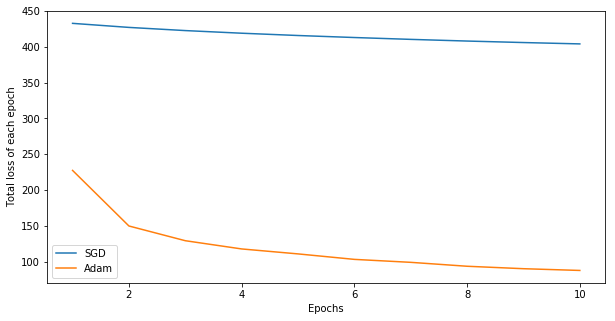

In [63]:
##Optimizaer
# plt.figure(figsize=(10,5))
# plt.plot([i+1 for i in range(len(sgd_acc))], sgd_acc, label = "SGD")
# plt.plot([i+1 for i in range(len(adam_acc))], adam_acc, label = "Adam")
# plt.xlabel("Batchs for every 100 iterations")
# plt.ylabel("Validate accuracy for every 100 iterations")
# plt.legend()
# plt.show()

plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(len(sgd_tr_ls))], sgd_tr_ls, label = "SGD")
plt.plot([i+1 for i in range(len(adam_tr_ls))], adam_tr_ls, label = "Adam")
plt.xlabel("Epochs")
plt.ylabel("Total loss of each epoch")
plt.legend()
plt.show()

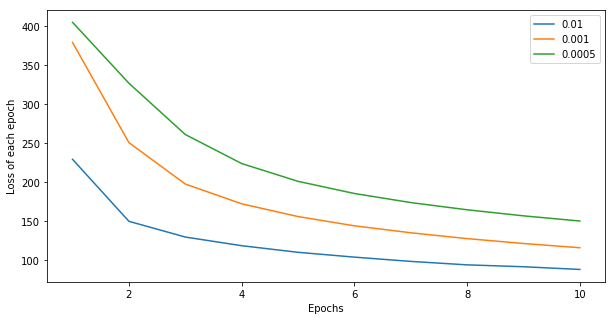

In [58]:
# Fixed learning rate and Learning rate decay
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(len(lr_001))], lr_001, label = "0.01")
plt.plot([i+1 for i in range(len(lr_0001))], lr_0001, label = "0.001")
plt.plot([i+1 for i in range(len(lr_00005))], lr_00005, label = "0.0005")
plt.plot([i+1 for i in range(len(lr_decay))], lr_decay, label = "learning decay")
plt.xlabel("Batchs for every 100 iterations")
plt.ylabel("Validate accuracy for every 100 iterations")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(len(lr_001_tr_ls))], lr_001_tr_ls, label = "0.01")
plt.plot([i+1 for i in range(len(lr_0001_tr_ls))], lr_0001_tr_ls, label = "0.001")
plt.plot([i+1 for i in range(len(lr_00005_tr_ls))], lr_00005_tr_ls, label = "0.0005")
# plt.plot([i+1 for i in range(len(lr_decay))], lr_decay, label = "learning decay")
plt.xlabel("Epochs")
plt.ylabel("Loss of each epoch")
plt.legend()
plt.show()

## Final Model and Result

In [78]:
'''
The best model has the combination, Lower_case only, 1 gram, Vocabulary size = 40000, 
embedding_size = 100, optimizer = Adam, learning_rate = 0.001, epochs = 10
'''

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        #check if the prediction is correct and get the data
        #print(data[0], predicted[0], labels.view_as(predicted)[0])
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [76]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 10 epochs
Val Acc 89.86
Test Acc 87.132


In [77]:
"""Convert token to id"""
new_dict = dict((v,k) for k,v in token2id.items())

In [80]:
def get_data(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        #check if the prediction is correct and get the data
        print(data[0], predicted[0], labels.view_as(predicted)[0])
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [ ]:
"""
map id to token

data is in the fail_correct_data.py
"""

##Incorrect (3 example)
new = []
for i in fail1:
    new += [new_dict[i]]
print(" ".join(new), '\n')


new = []
for i in fail2:
    new += [new_dict[i]]
print(" ".join(new), '\n')

new = []
for i in fail3:
    new += [new_dict[i]]
print(" ".join(new), '\n')

##Correct(3 example)
new = []
for i in correct1:
    new += [new_dict[i]]
print(" ".join(new) + '\n')

new = []
for i in correct2:
    new += [new_dict[i]]
print(" ".join(new), '\n')

new = []
for i in correct3:
    new += [new_dict[i]]
print(" ".join(new))

Incorrect:

it 's the <unk> starring reed hadley with an all star guest cast the film begins with an accidental convenient kidnapping which leads to one thing and another which does n't really indicate the main story which is a big house <unk> prison break story the story is very improbable to say the least it 's like a tv show only more violent for the <unk> /><br />but the cast is a trip picture this ralph <unk> is sent to prison his cell mates are the following criminals <unk> crawford <unk> <unk> jr. charles bronson reading a muscle magazine and william <unk> reading a detective magazine honest you should know that an early scene reveals what happens to the missing boy <unk> the ending <unk> if you do n't want to have that hanging do n't miss the opening scenes between the <unk> and the boy peter <unk> doing well as a runaway <unk> br /><br big house <unk> 1955 howard w. 

this film got terrible reviews but because it was offbeat and because critics do n't usually get offbeat films i thought i 'd give it a try unfortunately they were largely right in this <unk> /><br />the film just has an awkward feel too it that is most off putting the sort of feel that is impossible to describe but it 's not a good one to further <unk> things the script is a dull <unk> thing that is only vaguely interesting.<br /><br />the immensely talented thurman just <unk> through this mess creating barely an impact hurt and <unk> try in vain to add something to the film with enthusiastic performance but there is nothing in the script it may have been less embarrassing for them if they had merely chosen to drift and get it over with like <unk> /><br />one thing the <unk> film critics did fail to mention however is that the film is actually quite funny whether it be moments of accurate satire or some outrageously weird moments like when the <unk> in question chase hurt off their ranch with the smell of their <unk> ... <unk> ... front <unk> /><br />because of the <unk> <unk> throughout while i would n't recommend this film there is entertainment to be had and watching even <unk> get the blues is worthwhile for something different

director warren beatty 's intention to turn <unk> <unk> 's famous comic strip into a live action cartoon with beatty himself cast in the lead as the square <unk> detective had sweet <unk> of innocent nostalgia -- quite unusual and intriguing coming from warren beatty unfortunately the picture is <unk> ham fun for awhile but eventually <unk> dick tracy attempts to bring down mobster big boy <unk> aided by loving tess <unk> but <unk> up by evil <unk> <unk> for the first half hour or so the oscar winning art direction and set design are wonderful to <unk> but as the plot <unk> along predictably with no real <unk> in the writing things begin to <unk> al pacino got a surprise supporting oscar nomination as bad boy <unk> and madonna who is mostly used as a <unk> prop gets to sing stephen <unk> 's sooner or later i always get my man which <unk> the award for best original song lots of heart thanks to beatty -- who was dedicated to his vision -- but the picture is too cool and <unk> it lacks heat 1/2 from

Correct:

what a mess why was this movie made this and other movies of its caliber should be teaching tools on how not to make a movie children may like it but anyone over 10 may or will <unk> to make matters worse was the fact that such great talent like whoopi goldberg and <unk> <unk> <unk> were entirely wasted in a film <unk> of any notice

i almost saw this at an actual movie theatre an art house theatre no less but could n't make it there in the one whole week it played but yesterday i finally saw it on cable and ... well ... i was n't disappointed that 's for sure madonna has done it again yet another bomb when will this woman learn when will the studios learn or perhaps they already have since this film was largely dumped with little <unk> and deadly word of mouth one would hope that being directed by her talented husband who 's created some interesting and/or terribly entertaining work would bring out the same quality madonna showed in desperately seeking susan alas it just is n't meant to be for here she is at her very worst <unk> convinced of her own greatness the <unk> <unk> every frame she 's in made all the more unbearable by her <unk> faux british accent an accent that only <unk> the fact that her speaking voice is immature in quality and not especially pleasant this may sound unnecessarily cruel but listen to the woman and look at her films of say the past decade like a latter day bette davis there is an <unk> <unk> to not only her <unk> but to her very face and body which here despite the warm photography displayed throughout the film perhaps its only saving grace are done no <unk> to her credit the entire affair is so <unk> that one wonders if the world 's greatest actress on her best day could do anything with this mess no one involved escapes <unk> bruce <unk> actually seems <unk> to be on screen though poor <unk> <unk> seems to carry herself as if she 's actually in something good which had me thinking all the while denial ai n't just a river in egypt <unk> <unk> son of <unk> <unk> star of the italian original swept away ... is like his father before him immensely attractive and is n't altogether bad despite winning a <unk> nomination for worst actor but like almost everything else about this production it all comes back to madonna on whose shoulders rest the blame why her why not her husband director guy ritchie just who do you think was behind this remake what actress would n't want nearly every shot of a movie to be centered on her 

this is a very very early bugs bunny cartoon as a result the character is still in a transition period -- he is not drawn as <unk> as he later was and his voice is n't quite right in addition the chemistry between <unk> and bugs is a little unusual <unk> is some poor <unk> who buys bugs from a pet shop -- there is no gun or desire on his part to blast the bunny to <unk> however despite this this is still a very enjoyable film the early bugs was definitely more sassy and cruel than his later <unk> in later films he messed with <unk> <unk> sam and others because they started it -- they messed with the rabbit but in this film he is much more like <unk> duck of the late 30s and early 40s -- a jerk who just loves irritating others a true <unk> instead of the hero of the later cartoons while this is n't among the best bug bunny cartoons it sure is fun to watch and it 's interesting to see just how much he 's changed over the years